# Fine-tuning SWIN Transformer for Multi-label Image Classification

In [1]:
import torch.nn as nn
import torch.optim as optim
# from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
# from transformers import DeiTForImageClassification, DeiTFeatureExtractor
import wandb
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as T
from pathlib import Path
from PIL import Image
import datasets
import os
import json
import jsonlines
from timm import list_models, create_model
from transformers.optimization import get_cosine_schedule_with_warmup
import evaluate
from torch.nn.functional import one_hot
from torch.nn.utils.rnn import pad_sequence


d:\MA\food-datasets\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading

In [2]:
annotations_path = Path("../data/ingredients-101/Annotations/")
images_path = Path("../data/food-101/images/")
ingredients_path = 'ingredients_simplified.txt'
simplifications_path = Path("../data/ingredients-101/ingredients_simplification/")

In [3]:
def read_data(path, file):
    with open(path / file, 'r') as f:
        data = f.read().strip().split('\n')
    return data

In [4]:
train_images = read_data(annotations_path, 'train_images.txt')
val_images = read_data(annotations_path, 'val_images.txt')
test_images = read_data(annotations_path, 'test_images.txt')

train_labels = read_data(annotations_path, 'train_labels.txt')
val_labels = read_data(annotations_path, 'val_labels.txt')
test_labels = read_data(annotations_path, 'test_labels.txt')

base_ingredients = read_data(simplifications_path, 'baseIngredients.txt')
ingredients_simplified = read_data(annotations_path, ingredients_path)

In [5]:
train_images[:3]

['apple_pie/1005649', 'apple_pie/1014775', 'apple_pie/1026328']

In [6]:
train_labels[:3]

['0', '0', '0']

### Convert Ingredients List to Multi-label Format

In [7]:
ingredients_simplified[:3]

['butter,flour,sugar,brown sugar,apple,cinnamon,nut',
 'baby back ribs,apple,salt,mustard,brown sugar,worcestershire,gin,chili',
 'nut,cinnamon,bread,butter,phyllo dough,sugar,honey,lemon,baklava']

In [8]:
corrected_ingredients_simplified = [ingredient.strip() for sublist in ingredients_simplified for ingredient in sublist.split(',')]
corrected_ingredients_simplified[:10]

['butter',
 'flour',
 'sugar',
 'brown sugar',
 'apple',
 'cinnamon',
 'nut',
 'baby back ribs',
 'apple',
 'salt']

In [9]:
# get only the unique ingredients
unique_ingredients = list(set(corrected_ingredients_simplified))
num_unique_ingredients = len(unique_ingredients)
num_unique_ingredients

227

In [10]:
# sort the ingredients alphabetically
unique_ingredients.sort()

# create a dictionary with the ingredients as keys and the index as values
ingredient_to_idx = {ingredient: idx for idx, ingredient in enumerate(unique_ingredients)}
idx_to_ingredient = {idx: ingredient for ingredient, idx in ingredient_to_idx.items()}

# create the directory if it does not exist
os.makedirs('../data/food-ingredients', exist_ok=True)

# save to a file
with open('../data/food-ingredients/ingredient_to_idx.txt', 'w') as f:
    for key, value in ingredient_to_idx.items():
        f.write(f'{key}, {value}\n')

In [11]:
numerical_ingredients_simplified = [[ingredient_to_idx[ingredient.strip()] for ingredient in sublist.split(',')] for sublist in ingredients_simplified]

numerical_ingredients_simplified[:5]

[[36, 100, 206, 34, 5, 63, 143],
 [10, 5, 183, 141, 34, 224, 105, 54],
 [143, 63, 29, 36, 160, 206, 116, 124, 15],
 [21, 124, 105, 183, 159, 9, 7],
 [94, 204, 105, 190, 156, 42, 224, 91, 27, 78]]

In [12]:
# manually check the correctness of the conversion
print(idx_to_ingredient[183])

print([idx_to_ingredient[idx] for idx in numerical_ingredients_simplified[1]]) 

salt
['baby back ribs', 'apple', 'salt', 'mustard', 'brown sugar', 'worcestershire', 'gin', 'chili']


In [13]:
# Create a dictionary to map each class to its ingredients
class_to_ingredients = {i: ingredients for i, ingredients in enumerate(ingredients_simplified)}
class_to_ingredients

# save to a file
with open('../data/food-ingredients/class_to_ingredients.jsonl', 'w') as f:
    for key, value in class_to_ingredients.items():
        f.write(json.dumps({key: value}) + '\n')

In [14]:
# get longest ingredient list
max_len = max([len(sublist) for sublist in numerical_ingredients_simplified])
max_len

25

### Create Dataset

In [15]:
# create a jsonl file with the data

# def write_combined_data(file_path, set):
#     with jsonlines.open(file_path, 'w') as writer:
#         for image, label, ingredients in zip(f"{set}_images", f"{set}_labels", numerical_ingredients_simplified):
#             # train_images, train_labels, numerical_ingredients_simplified):
#             ingredients = class_to_ingredients[int(label)]
#             ingredients_numeric = [ingredient_to_idx[ingredient] for ingredient in ingredients.split(',')]
#             writer.write({'image': str(images_path) + '/' + image + '.jpg', 'ingredients': ingredients_numeric, 'ingredients_names': ingredients.split(','), 'class': int(label), 'class_name': image.split('/')[0]})
    
# write_combined_data('../data/food-ingredients/train.jsonl', 'train')
# write_combined_data('../data/food-ingredients/val.jsonl', 'val')
# write_combined_data('../data/food-ingredients/test.jsonl')+ 'test'
with jsonlines.open('../data/food-ingredients/train.jsonl', 'w') as writer:
    for image, label in zip(train_images, train_labels):
        ingredients = class_to_ingredients[int(label)]
        ingredients_numeric = [ingredient_to_idx[ingredient] for ingredient in ingredients.split(',')]
        writer.write({'image': str(images_path) + '/' + image + '.jpg', 'ingredients': ingredients_numeric, 'ingredients_names': ingredients.split(','), 'class': int(label), 'class_name': image.split('/')[0]})

with jsonlines.open('../data/food-ingredients/val.jsonl', 'w') as writer:
    for image, label in zip(val_images, val_labels):
        ingredients = class_to_ingredients[int(label)]
        ingredients_numeric = [ingredient_to_idx[ingredient] for ingredient in ingredients.split(',')]
        writer.write({'image': str(images_path) + '/' + image + '.jpg', 'ingredients': ingredients_numeric, 'ingredients_names': ingredients.split(','), 'class': int(label), 'class_name': image.split('/')[0]})

with jsonlines.open('../data/food-ingredients/test.jsonl', 'w') as writer:
    for image, label in zip(test_images, test_labels):
        ingredients = class_to_ingredients[int(label)]
        ingredients_numeric = [ingredient_to_idx[ingredient] for ingredient in ingredients.split(',')]
        writer.write({'image': str(images_path) + '/' + image + '.jpg', 'ingredients': ingredients_numeric, 'ingredients_names': ingredients.split(','), 'class': int(label), 'class_name': image.split('/')[0]})

In [16]:
# load dataset
data_files = {"train": "../data/food-ingredients/train.jsonl", "val": "../data/food-ingredients/val.jsonl", "test": "../data/food-ingredients/test.jsonl"}

dataset = datasets.load_dataset('json', data_files=data_files)

Generating train split: 68175 examples [00:00, 473542.39 examples/s]
Generating val split: 7575 examples [00:00, 625824.39 examples/s]
Generating test split: 25250 examples [00:00, 855593.15 examples/s]


In [17]:
# def pad_labels(batch):
#     # Convert lists to tensors and pad shorter lists
#     if len(batch['ingredients']) > 0:
#         # Convert each scalar to a 1D tensor
#         batch['ingredients'] = pad_sequence([torch.tensor([x]) for x in batch['ingredients']], batch_first=True)
#     else:
#         # Replace empty list with tensor of zeros
#         batch['ingredients'] = torch.zeros(1, max_len)  # Replace 'desired_length' with the length you want
#     return batch

# dataset = dataset.map(pad_labels)

### Visual Inspection

In [18]:
# def show_samples(ds,rows,cols):
#     # selecting random images with randomstate
#     samples = ds.shuffle(seed=20).select(range(rows*cols))
#     fig = plt.figure(figsize=(cols*4,rows*4))
#     # plotting
#     for i in range(rows*cols):
#         img = samples[i]['image']
#         # add full path and open image
#         img = Image.open(img)

#         labels = samples[i]['ingredients']
#         # getting string labels and combining them with a comma
#         labels = ','.join([idx_to_ingredient[lb] for lb in labels])
#         fig.add_subplot(rows,cols,i+1)
#         plt.imshow(img)
#         plt.title(labels)
#         plt.axis('off')
            
# show_samples(dataset['train'],rows=2,cols=2)

### Perform Transformations

In [19]:
img_size = (224,224)

tfms = T.Compose([
    T.Resize(img_size),
    T.RandomHorizontalFlip(),
    T.RandomRotation(30),
    T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize(
        mean = (0.5,0.5,0.5),
         std = (0.5,0.5,0.5)
    )
])

valid_tfms = T.Compose([
    T.Resize(img_size),
    T.ToTensor(),
    T.Normalize(
        mean = (0.5,0.5,0.5),
         std = (0.5,0.5,0.5)
    )
])


In [20]:
# def transforms(batch):
#     # convert all images in batch to RGB to avoid grayscale or transparent images
#     batch['image'] = [Image.open(x).convert('RGB') for x in batch['image']]
#     # apply torchvision.transforms per sample in the batch
#     inputs = [tfms(x) for x in batch['image']]
#     batch['pixel_values'] = inputs

#     # pad the labels
#     ingredients_tensors = [torch.tensor(x) for x in batch['ingredients']]

#     # padded_ingredients = pad_sequence(batch['ingredients'], batch_first=True)
#     labels = pad_sequence(ingredients_tensors, batch_first=True)
    
#     # one-hot encoding the labels
#     # labels = torch.tensor(padded_ingredients)
#     batch['labels'] = nn.functional.one_hot(labels,num_classes=num_unique_ingredients).sum(dim=1)
    
#     return batch


def transforms(batch):
    batch['image'] = [Image.open(x).convert('RGB') for x in batch['image']]
    inputs = [tfms(x) for x in batch['image']]
    batch['pixel_values'] = inputs

    # Umwandlung der Zutatenindizes in One-Hot-Encoded Labels
    max_num_labels = max(len(x) for x in batch['ingredients'])  # Finden Sie die maximale Anzahl von Labels in einem Bild
    labels = torch.zeros((len(batch['ingredients']), num_unique_ingredients))

    for i, ingredient_indices in enumerate(batch['ingredients']):
        labels[i, ingredient_indices] = 1

    batch['labels'] = labels

    return batch



# def transforms(batch):
#     for i in range(len(batch['image'])):
#         img = Image.open(batch['image'][i]).convert('RGB')

#         # Testing Variant 1
#         inputs = [tfms(x) for x in batch['image']]
#         batch['pixel_values'] = inputs
#         # Working Variant 2
#         # img = tfms(img)

#         batch['image'][i] = img

#          # one-hot encoding the labels
#         labels = torch.tensor(batch['classes'])
#         batch['labels'] = nn.functional.one_hot(labels,num_classes=num_unique_ingredients).sum(dim=1)
#     return batch


def valid_transforms(batch):
    batch['image'] = [Image.open(x).convert('RGB') for x in batch['image']]
    inputs = [tfms(x) for x in batch['image']]
    batch['pixel_values'] = inputs
    
    # one-hot encoding the labels
    labels = torch.tensor(batch['classes'])
    batch['labels'] = nn.functional.one_hot(labels,num_classes=20).sum(dim=1)
    
    return batch

def transforms_valid(batch):
    for i in range(len(batch['image'])):
        img = Image.open(batch['image'][i]).convert('RGB')
        img = valid_tfms(img)
        batch['image'][i] = img
    return batch

In [21]:
# Apply the transformations to the dataset
train_dataset = dataset['train'].with_transform(transforms)
valid_dataset = dataset['val'].with_transform(transforms)
test_dataset = dataset['test'].with_transform(transforms)

len(train_dataset), len(valid_dataset), len(test_dataset)

(68175, 7575, 25250)

In [22]:
train_dataset

Dataset({
    features: ['image', 'ingredients', 'ingredients_names', 'class', 'class_name'],
    num_rows: 68175
})

In [23]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.stack([x['labels'] for x in batch]).float()
    }

# def collate_fn(batch):
#     # Separate the inputs and labels
#     inputs = [item['pixel_values'] for item in batch]
#     labels = [item['ingredients'] for item in batch]

#     # Pad the labels to the same length
#     labels = pad_sequence([torch.tensor(label) for label in labels], batch_first=True)

#     # Convert to one-hot encoding
#     one_hot_labels = torch.zeros((len(labels), num_unique_ingredients))
#     for i, label in enumerate(labels):
#         one_hot_labels[i, label] = 1

#     # Stack the inputs into a tensor
#     inputs = torch.stack(inputs)

#     return {'image': inputs, 'ingredients': one_hot_labels}

In [24]:
# # # uncomment for testing with less data

# # Anzahl der zu verwendenden Samples festlegen
# from sklearn.model_selection import train_test_split
# from torch.utils.data import Subset


# subset_size = 0.1  # Nutze 10% der Daten
# train_indices, _ = train_test_split(range(len(train_dataset)), train_size=subset_size, random_state=42)
# valid_indices, _ = train_test_split(range(len(valid_dataset)), train_size=subset_size, random_state=42)
# test_indices, _ = train_test_split(range(len(test_dataset)), train_size=subset_size, random_state=42)

# # Erstellen der Subsets
# train_subset = Subset(train_dataset, train_indices)
# valid_subset = Subset(valid_dataset, valid_indices)
# test_subset = Subset(test_dataset, test_indices)

# # Erstellen der DataLoader
# train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=collate_fn)
# valid_loader = DataLoader(valid_subset, batch_size=32, shuffle=False, collate_fn=collate_fn)
# test_loader = DataLoader(test_subset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [25]:
# create DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [26]:
# check size of the data
len(train_loader), len(valid_loader), len(test_loader)

(8522, 947, 3157)

In [27]:
train_loader.dataset[0]

# print firt batch
for batch in train_loader:
    print(batch['pixel_values'].shape)
    print(batch['labels'].shape)
    break

torch.Size([8, 3, 224, 224])
torch.Size([8, 227])


## Train Model

In [28]:
os.environ["WANDB_NOTEBOOK_NAME"] = 'swin-fine-tuning-multi-label.ipynb'

In [29]:
# import time

# from tqdm import tqdm

# def train(model_name, batch_size=8, epochs=1, lr=2e-4):
#     os.environ["WANDB_DISABLE_SYMLINKS"] = "1"
#     wandb.init(project="finetuning-vit", config={
#         "model_name": model_name,
#         "batch_size": batch_size,
#         "epochs": epochs,
#         "learning_rate": lr
#     })

#     # TODO: change to right project name
#     # wandb.init(project=model_name+"-finetuning", config={
#     #     "model_name": model_name,
#     #     "batch_size": batch_size,
#     #     "epochs": epochs,
#     #     "learning_rate": lr
#     # })
#     config = wandb.config
    
#     device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#     print(f'Using {device}')

#     # Debug: Model Load
#     print("Loading the model...")
#     model = create_model(model_name, num_classes=num_unique_ingredients)

#     print(num_unique_ingredients)
#     model.to(device)
#     print("Model loaded.")

#     optimizer = optim.AdamW(model.parameters(), lr=lr)
#     loss_fn = nn.BCEWithLogitsLoss()
#     scheduler = get_cosine_schedule_with_warmup(
#         optimizer,
#         num_warmup_steps=int(0.1 * len(train_loader)),
#         num_training_steps=len(train_loader) * epochs
#     )

#     for epoch in range(epochs):
#         model.train()
#         train_metric = evaluate.load('roc_auc', 'multilabel')
#         running_loss = 0.0

#         print(f"Starting training epoch {epoch}...")

#         # for batch in train_dl:
            
#         #     logits = model(batch['pixel_values'])
            
#         #     loss = loss_fn(logits,batch['labels'])
#         #     accelerator.backward(loss) # backpropagation
#         #     optimizer.step() # update weights
#         #     scheduler.step() # update LR
#         #     optimizer.zero_grad() # set grad values to zero
            
#         #     running_loss += loss.item() # keep track of loss

#         for batch in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
#             # logits = model(batch['pixel_values'])
#             inputs = batch['pixel_values'].to(device)
#             logits = model(inputs)
#             labels = batch['labels'].to(device) 
#             print(f"{logits.shape = } | {labels.shape = }")     

#             loss = loss_fn(logits, labels)
#             loss.backward() # backpropagation
#             optimizer.step() # update weights
#             scheduler.step() # update LR
#             optimizer.zero_grad() # set grad values to zero

#             running_loss += loss.item() # keep track of loss
#             train_metric.add_batch(references=labels.cpu(), prediction_scores=logits.cpu())


#         # for batch in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
#         #     print(batch)
#         #     logits = model(batch['pixel_values'])

#         #     # inputs = batch['image'].to(device)
#         #     # labels = batch['ingredients'].to(device)
            
#         #     optimizer.zero_grad()
#         #     outputs = model(inputs)
#         #     loss = loss_fn(outputs, labels)
#         #     loss.backward()
#         #     optimizer.step()
#         #     scheduler.step()
            
#         #     running_loss += loss.item()
#         #     train_metric.add_batch(references=labels.cpu(), prediction_scores=outputs.cpu())
        
        
#         train_loss = running_loss / len(train_loader)
#         train_roc_auc = train_metric.compute(average='micro')['roc_auc']
        
#         print(f"\n{epoch = }")
#         print(f"{train_loss = :.3f} | {train_roc_auc = :.3f}")
        
#         wandb.log({"train_loss": train_loss, "train_roc_auc": train_roc_auc, "epoch": epoch})
        

#         model.eval()
#         running_loss = 0.0
#         valid_metric = evaluate.load('roc_auc', 'multilabel')
        
#         print(f"Starting validation epoch {epoch}...")
#         val_start_time = time.time()
        
        
#         for batch in tqdm(valid_loader, desc=f"Validation Epoch {epoch}"):
#             with torch.no_grad():
#                 inputs = batch['pixel_values'].to(device)
#                 logits = model(batch['pixel_values'])
#             labels = batch['labels'].to(device)
#             loss = loss_fn(logits, labels)
#             running_loss += loss.item()
#             valid_metric.add_batch(references=labels.cpu(), prediction_scores=logits.cpu())


#         # with torch.no_grad():
#         #     for batch in tqdm(valid_loader, desc=f"Validation Epoch {epoch}"):
#         #         inputs = batch['image'].to(device)
#         #         labels = batch['ingredients'].to(device)
#         #         outputs = model(inputs)
#         #         loss = loss_fn(outputs, labels)
#         #         running_loss += loss.item()
#         #         valid_metric.add_batch(references=labels.cpu(), prediction_scores=outputs.cpu())
        
#         val_end_time = time.time()
#         print(f"Completed validation epoch {epoch} in {val_end_time - val_start_time:.2f} seconds")
        
#         valid_loss = running_loss / len(valid_loader)
#         valid_roc_auc = valid_metric.compute(average='micro')['roc_auc']
        
#         print(f"{valid_loss = :.3f} | {valid_roc_auc = :.3f}")
        
#         wandb.log({"valid_loss": valid_loss, "valid_roc_auc": valid_roc_auc, "epoch": epoch})
        
#         model_path = f'./models/{model_name}-pascal-epoch-{epoch}.pth'
#         torch.save(model.state_dict(), model_path)


    
#     test_metric = evaluate.load('roc_auc', 'multilabel')
    
#     print(f"Starting test evaluation...")
#     test_start_time = time.time()

#     for batch in tqdm(test_loader, desc="Testing"):
#         with torch.no_grad():
#             inputs = batch['pixel_values'].to(device)
#             logits = model(inputs)
#         labels = batch['labels'].to(device)
#         test_metric.add_batch(references=labels.cpu(), prediction_scores=logits.cpu())
    
#     # with torch.no_grad():
#     #     for batch in tqdm(test_loader, desc="Testing"):
#     #         inputs = batch['image'].to(device)
#     #         labels = batch['ingredients'].to(device)
#     #         outputs = model(inputs)
#     #         test_metric.add_batch(references=labels.cpu(), prediction_scores=outputs.cpu())
    
#     test_end_time = time.time()
#     print(f"Completed test evaluation in {test_end_time - test_start_time:.2f} seconds")
    
#     test_roc_auc = test_metric.compute(average='micro')['roc_auc']
#     print(f"\n\nTEST AUROC: {test_roc_auc:.3f}")
    
#     wandb.log({"test_roc_auc": test_roc_auc})

#     wandb.finish()

#     return model

In [30]:
import numpy as np

from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score

def multi_label_f1_micro(y_true, y_pred, threshold=0.25, average='micro', labels=None, pos_label=1, sample_weight=None):
    y_pred = (y_pred > threshold).astype(int)
    return f1_score(y_true, y_pred, average=average, labels=labels, pos_label=pos_label, sample_weight=sample_weight, zero_division=0.0)

def multi_label_f1_macro(y_true, y_pred, threshold=0.25, average='macro', labels=None, pos_label=1, sample_weight=None):
    y_pred = (y_pred > threshold).astype(int)
    return f1_score(y_true, y_pred, average=average, labels=labels, pos_label=pos_label, sample_weight=sample_weight, zero_division=0.0)

def multi_label_f1_weighted(y_true, y_pred, threshold=0.25, average='weighted', labels=None, pos_label=1, sample_weight=None):
    y_pred = (y_pred > threshold).astype(int)
    return f1_score(y_true, y_pred, average=average, labels=labels, pos_label=pos_label, sample_weight=sample_weight, zero_division=0.0)

def multi_label_f1_samples(y_true, y_pred, threshold=0.25, average='samples', labels=None, pos_label=1, sample_weight=None):
    y_pred = (y_pred > threshold).astype(int)
    return f1_score(y_true, y_pred, average=average, labels=labels, pos_label=pos_label, sample_weight=sample_weight, zero_division=0.0)

# did not work, suddenly always returned 0.0
# def multi_label_accuracy(y_true, y_pred, threshold=0.25):
#     print(y_true, y_pred)
#     y_true = 1
#     y_pred = 1
#     y_pred = (y_pred > threshold).astype(int)
#     return accuracy_score(y_true, y_pred)

def multi_label_accuracy(y_true, y_pred, threshold=0.25):
    y_pred = (y_pred > threshold).astype(int)
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = y_true.shape[0] * y_true.shape[1]
    accuracy = correct_predictions / total_predictions
    return accuracy


def multi_label_recall(y_true, y_pred, threshold=0.25, average='micro', labels=None, pos_label=1, sample_weight=None):
    y_pred = (y_pred > threshold).astype(int)
    return recall_score(y_true, y_pred, average=average, labels=labels, pos_label=pos_label, sample_weight=sample_weight, zero_division=0.0)

def multi_label_precision(y_true, y_pred, threshold=0.25, average='micro', labels=None, pos_label=1, sample_weight=None):
    y_pred = (y_pred > threshold).astype(int)
    return precision_score(y_true, y_pred, average=average, labels=labels, pos_label=pos_label, sample_weight=sample_weight, zero_division=0.0)

def multi_label_roc_auc(y_true, y_pred, average='micro', sample_weight=None, max_fpr=None):
    return roc_auc_score(y_true, y_pred, average=average, sample_weight=sample_weight, max_fpr=max_fpr)


In [31]:
import time

from tqdm import tqdm

def train(model_name, batch_size=8, epochs=1, lr=2e-4):
    os.environ["WANDB_DISABLE_SYMLINKS"] = "1"
    wandb.init(project="finetuning-vit", config={
        "model_name": model_name,
        "batch_size": batch_size,
        "epochs": epochs,
        "learning_rate": lr
    })

    config = wandb.config
    
    device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
    print(f'Using {device}')

    # Debug: Model Load
    print("Loading the model...")
    model = create_model(model_name, num_classes=num_unique_ingredients)

    print(num_unique_ingredients)
    model.to(device)
    print("Model loaded.")

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * len(train_loader)),
        num_training_steps=len(train_loader) * epochs
    )

    for epoch in range(epochs):

        ## Training

        model.train()
        train_metric = evaluate.load('roc_auc', 'multilabel')
        running_loss = 0.0
        predictions, actuals = [], []

        print(f"Starting training epoch {epoch}...")

        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
            # logits = model(batch['pixel_values'])
            inputs = batch['pixel_values'].to(device)
            logits = model(inputs)
            labels = batch['labels'].to(device) 

            loss = loss_fn(logits, labels)
            loss.backward() # backpropagation
            optimizer.step() # update weights
            scheduler.step() # update LR
            optimizer.zero_grad() # set grad values to zero

            running_loss += loss.item() # keep track of loss
            train_metric.add_batch(references=labels.cpu(), prediction_scores=logits.cpu())

            
            predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
            actuals.append(labels.cpu().numpy())

        predictions = np.vstack(predictions)
        actuals = np.vstack(actuals)

        print("Unique values in labels:", np.unique(actuals))
        is_binary = np.all(np.isin(actuals, [0, 1]))
        print("Data is binary:", is_binary)
        
        
        train_loss = running_loss / len(train_loader)
        train_roc_auc = train_metric.compute(average='micro')['roc_auc']
        train_f1_micro = multi_label_f1_micro(actuals, predictions)
        train_f1_macro = multi_label_f1_macro(actuals, predictions)
        train_f1_weighted = multi_label_f1_weighted(actuals, predictions)
        train_f1_samples = multi_label_f1_samples(actuals, predictions)
        train_accuracy = multi_label_accuracy(actuals, predictions)
        train_recall = multi_label_recall(actuals, predictions)
        train_precision = multi_label_precision(actuals, predictions)

        
        print(f"\n{epoch = }")
        print(f"{train_loss = :.3f} | {train_roc_auc = :.3f}")
        
        wandb.log({"train_loss": train_loss, "train_roc_auc": train_roc_auc, "epoch": epoch, "train_f1_micro": train_f1_micro, "train_f1_macro": train_f1_macro, "train_f1_weighted": train_f1_weighted, "train_f1_samples": train_f1_samples, "train_accuracy": train_accuracy, "train_recall": train_recall, "train_precision": train_precision})
        
        ## Validation

        model.eval()
        running_loss = 0.0
        valid_metric = evaluate.load('roc_auc', 'multilabel')
        
        print(f"Starting validation epoch {epoch}...")
        val_start_time = time.time()
        
        
        for batch in tqdm(valid_loader, desc=f"Validation Epoch {epoch}"):
            with torch.no_grad():
                inputs = batch['pixel_values'].to(device)
                logits = model(inputs)
                labels = batch['labels'].to(device) 
            loss = loss_fn(logits, labels)
            running_loss += loss.item()
            valid_metric.add_batch(references=labels.cpu(), prediction_scores=logits.cpu())
        
        val_end_time = time.time()
        print(f"Completed validation epoch {epoch} in {val_end_time - val_start_time:.2f} seconds")
        
        valid_loss = running_loss / len(valid_loader)
        valid_roc_auc = valid_metric.compute(average='micro')['roc_auc']
        valid_f1_micro = multi_label_f1_micro(actuals, predictions)
        valid_f1_macro = multi_label_f1_macro(actuals, predictions)
        valid_f1_weighted = multi_label_f1_weighted(actuals, predictions)
        valid_f1_samples = multi_label_f1_samples(actuals, predictions)
        valid_accuracy = multi_label_accuracy(actuals, predictions)
        valid_recall = multi_label_recall(actuals, predictions)
        valid_precision = multi_label_precision(actuals, predictions)

        
        print(f"{valid_loss = :.3f} | {valid_roc_auc = :.3f}")
        
        wandb.log({"valid_loss": valid_loss, "valid_roc_auc": valid_roc_auc, "epoch": epoch, "valid_f1_micro": valid_f1_micro, "valid_f1_macro": valid_f1_macro, "valid_f1_weighted": valid_f1_weighted, "valid_f1_samples": valid_f1_samples, "valid_accuracy": valid_accuracy, "valid_recall": valid_recall, "valid_precision": valid_precision})
        
        model_path = f'./models/{model_name}-pascal-epoch-{epoch}.pth'
        torch.save(model.state_dict(), model_path)


    ## Testing
    
    test_metric = evaluate.load('roc_auc', 'multilabel')
    
    print(f"Starting test evaluation...")
    test_start_time = time.time()

    for batch in tqdm(test_loader, desc="Testing"):
        with torch.no_grad():
            inputs = batch['pixel_values'].to(device)
            logits = model(inputs)
            labels = batch['labels'].to(device)
        test_metric.add_batch(references=labels.cpu(), prediction_scores=logits.cpu())
    
    test_end_time = time.time()
    print(f"Completed test evaluation in {test_end_time - test_start_time:.2f} seconds")
    
    test_roc_auc = test_metric.compute(average='micro')['roc_auc']
    test_f1_micro = multi_label_f1_micro(actuals, predictions)
    test_f1_macro = multi_label_f1_macro(actuals, predictions)
    test_f1_weighted = multi_label_f1_weighted(actuals, predictions)
    test_f1_samples = multi_label_f1_samples(actuals, predictions)
    test_accuracy = multi_label_accuracy(actuals, predictions)
    test_recall = multi_label_recall(actuals, predictions)
    test_precision = multi_label_precision(actuals, predictions)



    print(f"\n\nTEST AUROC: {test_roc_auc:.3f}")
    
    wandb.log({"test_roc_auc": test_roc_auc, "test_f1_micro": test_f1_micro, "test_f1_macro": test_f1_macro, "test_f1_weighted": test_f1_weighted, "test_f1_samples": test_f1_samples, "test_accuracy": test_accuracy, "test_recall": test_recall, "test_precision": test_precision})

    wandb.finish()

    return model

In [32]:
# model_name = 'volo_d1_224'
model_name = 'volo_d3_224'
# model_name = 'swin_base_patch4_window7_224'
# model_name = 'deit3_medium_patch16_224'
# model_name = 'swin_s3_small_224'
# model_name = 'resnet18'
# train the model
model = train(model_name, batch_size=32, epochs=15, lr=2e-4)

wandb: Currently logged in as: ahirsch (htwbe). Use `wandb login --relogin` to force relogin


Using cuda:1
Loading the model...
227
Model loaded.
Starting training epoch 0...


Training Epoch 0: 100%|██████████| 8522/8522 [51:04<00:00,  2.78it/s]  


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 0
train_loss = 0.138 | train_roc_auc = 0.796
Starting validation epoch 0...


Validation Epoch 0: 100%|██████████| 947/947 [02:39<00:00,  5.93it/s]


Completed validation epoch 0 in 159.68 seconds
valid_loss = 0.132 | valid_roc_auc = 0.810
Starting training epoch 1...


Training Epoch 1: 100%|██████████| 8522/8522 [42:29<00:00,  3.34it/s]


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 1
train_loss = 0.131 | train_roc_auc = 0.817
Starting validation epoch 1...


Validation Epoch 1: 100%|██████████| 947/947 [02:34<00:00,  6.13it/s]


Completed validation epoch 1 in 154.60 seconds
valid_loss = 0.130 | valid_roc_auc = 0.823
Starting training epoch 2...


Training Epoch 2: 100%|██████████| 8522/8522 [43:02<00:00,  3.30it/s]  


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 2
train_loss = 0.128 | train_roc_auc = 0.835
Starting validation epoch 2...


Validation Epoch 2: 100%|██████████| 947/947 [02:34<00:00,  6.11it/s]


Completed validation epoch 2 in 154.89 seconds
valid_loss = 0.126 | valid_roc_auc = 0.847
Starting training epoch 3...


Training Epoch 3: 100%|██████████| 8522/8522 [12:29:04<00:00,  5.27s/it]        


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 3
train_loss = 0.125 | train_roc_auc = 0.851
Starting validation epoch 3...


Validation Epoch 3: 100%|██████████| 947/947 [02:42<00:00,  5.82it/s]


Completed validation epoch 3 in 162.72 seconds
valid_loss = 0.124 | valid_roc_auc = 0.858
Starting training epoch 4...


Training Epoch 4: 100%|██████████| 8522/8522 [52:21<00:00,  2.71it/s]  


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 4
train_loss = 0.121 | train_roc_auc = 0.867
Starting validation epoch 4...


Validation Epoch 4: 100%|██████████| 947/947 [02:11<00:00,  7.20it/s]


Completed validation epoch 4 in 131.55 seconds
valid_loss = 0.119 | valid_roc_auc = 0.877
Starting training epoch 5...


Training Epoch 5: 100%|██████████| 8522/8522 [44:41<00:00,  3.18it/s]  


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 5
train_loss = 0.118 | train_roc_auc = 0.881
Starting validation epoch 5...


Validation Epoch 5: 100%|██████████| 947/947 [02:42<00:00,  5.83it/s]


Completed validation epoch 5 in 162.34 seconds
valid_loss = 0.115 | valid_roc_auc = 0.888
Starting training epoch 6...


Training Epoch 6: 100%|██████████| 8522/8522 [42:17<00:00,  3.36it/s]  


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 6
train_loss = 0.114 | train_roc_auc = 0.891
Starting validation epoch 6...


Validation Epoch 6: 100%|██████████| 947/947 [02:11<00:00,  7.20it/s]


Completed validation epoch 6 in 131.55 seconds
valid_loss = 0.114 | valid_roc_auc = 0.892
Starting training epoch 7...


Training Epoch 7: 100%|██████████| 8522/8522 [2:21:55<00:00,  1.00it/s]       


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 7
train_loss = 0.111 | train_roc_auc = 0.899
Starting validation epoch 7...


Validation Epoch 7: 100%|██████████| 947/947 [02:42<00:00,  5.82it/s]


Completed validation epoch 7 in 162.60 seconds
valid_loss = 0.109 | valid_roc_auc = 0.903
Starting training epoch 8...


Training Epoch 8: 100%|██████████| 8522/8522 [44:56<00:00,  3.16it/s]  


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 8
train_loss = 0.108 | train_roc_auc = 0.907
Starting validation epoch 8...


Validation Epoch 8: 100%|██████████| 947/947 [01:47<00:00,  8.82it/s]


Completed validation epoch 8 in 107.35 seconds
valid_loss = 0.107 | valid_roc_auc = 0.909
Starting training epoch 9...


Training Epoch 9: 100%|██████████| 8522/8522 [39:21<00:00,  3.61it/s]  


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 9
train_loss = 0.105 | train_roc_auc = 0.914
Starting validation epoch 9...


Validation Epoch 9: 100%|██████████| 947/947 [01:47<00:00,  8.80it/s]


Completed validation epoch 9 in 107.57 seconds
valid_loss = 0.105 | valid_roc_auc = 0.913
Starting training epoch 10...


Training Epoch 10: 100%|██████████| 8522/8522 [39:40<00:00,  3.58it/s] 


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 10
train_loss = 0.102 | train_roc_auc = 0.919
Starting validation epoch 10...


Validation Epoch 10: 100%|██████████| 947/947 [02:36<00:00,  6.03it/s]


Completed validation epoch 10 in 156.95 seconds
valid_loss = 0.104 | valid_roc_auc = 0.916
Starting training epoch 11...


Training Epoch 11: 100%|██████████| 8522/8522 [49:00<00:00,  2.90it/s]  


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 11
train_loss = 0.100 | train_roc_auc = 0.924
Starting validation epoch 11...


Validation Epoch 11: 100%|██████████| 947/947 [02:19<00:00,  6.80it/s]


Completed validation epoch 11 in 139.26 seconds
valid_loss = 0.102 | valid_roc_auc = 0.920
Starting training epoch 12...


Training Epoch 12: 100%|██████████| 8522/8522 [40:31<00:00,  3.50it/s]  


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 12
train_loss = 0.098 | train_roc_auc = 0.928
Starting validation epoch 12...


Validation Epoch 12: 100%|██████████| 947/947 [02:09<00:00,  7.32it/s]


Completed validation epoch 12 in 129.42 seconds
valid_loss = 0.101 | valid_roc_auc = 0.921
Starting training epoch 13...


Training Epoch 13: 100%|██████████| 8522/8522 [40:11<00:00,  3.53it/s]


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 13
train_loss = 0.096 | train_roc_auc = 0.930
Starting validation epoch 13...


Validation Epoch 13: 100%|██████████| 947/947 [02:13<00:00,  7.08it/s]


Completed validation epoch 13 in 133.79 seconds
valid_loss = 0.101 | valid_roc_auc = 0.922
Starting training epoch 14...


Training Epoch 14: 100%|██████████| 8522/8522 [39:28<00:00,  3.60it/s]  


Unique values in labels: [0. 1.]
Data is binary: True

epoch = 14
train_loss = 0.096 | train_roc_auc = 0.931
Starting validation epoch 14...


Validation Epoch 14: 100%|██████████| 947/947 [02:10<00:00,  7.27it/s]


Completed validation epoch 14 in 130.33 seconds
valid_loss = 0.101 | valid_roc_auc = 0.921
Starting test evaluation...


Testing: 100%|██████████| 3157/3157 [08:22<00:00,  6.28it/s]


Completed test evaluation in 502.60 seconds


TEST AUROC: 0.931


In [33]:
# from sklearn.metrics import roc_auc_score
# import numpy as np

# def train(model_name, batch_size=8, epochs=1, lr=2e-4):
#     device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#     model = create_model(model_name, num_classes=num_unique_ingredients).to(device)
#     optimizer = optim.AdamW(model.parameters(), lr=lr)
#     loss_fn = nn.BCEWithLogitsLoss()
#     scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=0)

#     for epoch in range(epochs):
#         model.train()
#         predictions, actuals = [], []
#         for batch in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
#             inputs = batch['pixel_values'].to(device)
#             labels = batch['labels'].to(device)
#             optimizer.zero_grad()
#             logits = model(inputs)
#             loss = loss_fn(logits, labels)
#             loss.backward()
#             optimizer.step()
#             scheduler.step()

#             predictions.append(torch.sigmoid(logits).detach().cpu().numpy())
#             actuals.append(labels.cpu().numpy())

#         predictions = np.vstack(predictions)
#         actuals = np.vstack(actuals)

#         print("Unique values in labels:", np.unique(actuals))
#         is_binary = np.all(np.isin(actuals, [0, 1]))
#         print("Data is binary:", is_binary)

#         roc_aucs = []
#         for i in range(num_unique_ingredients):
#             # Überprüfen, ob gültige Labels vorhanden sind
#             if np.unique(actuals[:, i]).size > 1:
#                 try:
#                     roc_auc = roc_auc_score(actuals[:, i], predictions[:, i])
#                     roc_aucs.append(roc_auc)
#                 except ValueError as e:
#                     print(f"Error calculating ROC AUC for class {i}: {e}")

#         if roc_aucs:
#             avg_roc_auc = np.mean(roc_aucs)
#             print(f"Epoch {epoch}: Average ROC AUC = {avg_roc_auc:.3f}")

#     return model


In [34]:
# import torch
# import torch.optim as optim
# import torch.nn as nn
# from evaluate import load as evaluate_load
# import wandb
# import os
# import time
# from tqdm import tqdm
# def train(model_name, batch_size=8, epochs=1, lr=2e-4):
#     # Ensure your device setup and model imports are handled before this
#     device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

#     # Initialize WandB for tracking experiments
#     wandb.init(project="finetuning-vit", config={
#         "model_name": model_name,
#         "batch_size": batch_size,
#         "epochs": epochs,
#         "learning_rate": lr
#     })

#     config = wandb.config

#     # Model setup, optimizer, and scheduler details should be handled according to your model's requirements
#     model = create_model(config.model_name, num_classes=num_unique_ingredients).to(device)
#     optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate)
#     loss_fn = nn.BCEWithLogitsLoss()
#     scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=0)  # Adjust these values based on your train_loader

#     # ROC AUC Metric setup for multilabel
#     train_metric = evaluate_load('roc_auc', task='multilabel')
#     valid_metric = evaluate_load('roc_auc', task='multilabel')
#     test_metric = evaluate_load('roc_auc', task='multilabel')

#     for epoch in range(config.epochs):
#         model.train()
#         running_loss = 0.0

#         for batch in tqdm(train_loader, desc=f"Training Epoch {epoch}"):
#             inputs = batch['pixel_values'].to(device)
#             logits = model(inputs)
#             labels = batch['labels'].to(device)

#             loss = loss_fn(logits, labels)
#             loss.backward()
#             optimizer.step()
#             scheduler.step()
#             optimizer.zero_grad()

#             running_loss += loss.item()
#             probabilities = torch.sigmoid(logits)  # Convert logits to probabilities

#             # Directly pass the labels and probabilities
#             train_metric.add_batch(references=labels.cpu(), prediction_scores=probabilities.detach().cpu())

#         train_loss = running_loss / len(train_loader)
#         train_roc_auc = train_metric.compute()['roc_auc']
#         wandb.log({"train_loss": train_loss, "train_roc_auc": train_roc_auc, "epoch": epoch})

#         # Validation loop with similar structure, and similar adjustments for test loop
#         # ... (replicate the above adjustments for validation and testing)

#     wandb.finish()


In [35]:
import timm

timm.list_models()


['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

## Manually test model

In [36]:
# load model from file
model = create_model(model_name, pretrained=True, num_classes=num_unique_ingredients)
state_dict = torch.load(f"./models/{model_name}-pascal-epoch-4.pth")
model.load_state_dict(state_dict)
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [37]:
# make predictions for 4 random images in the test set

# get random images
import random
random.seed(42)

# get random indices
indices = random.sample(range(len(test_dataset)), 4)

# get the images and labels
images = [test_dataset[i]['image'] for i in indices]
labels = [test_dataset[i]['labels'] for i in indices]

# images, labels

In [38]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]], device='cuda:1') | tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1

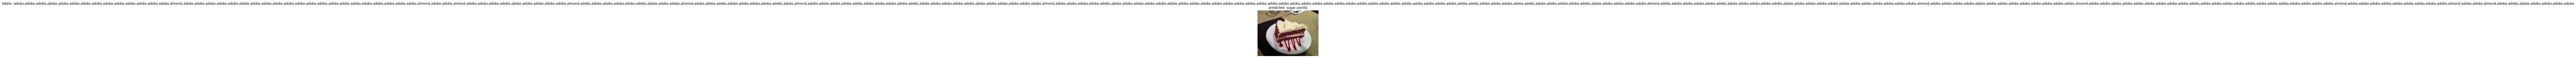

In [39]:
def show_predictions(rows=2, cols=4):
    model.eval()
    samples = test_dataset.shuffle(seed=42).select(np.arange(rows * cols))
    fig = plt.figure(figsize=(cols * 4, rows * 4))
    
    for i in range(rows * cols):
        # img = samples[i]['image']
        img = samples[i]['image']
        inputs = samples[i]['pixel_values'].unsqueeze(0).to(device)
        labels = samples[i]['labels']

        print(f"{inputs} | {labels}")

        # Transformiere das Bild, um es dem Modell zu übergeben
        # img_transformed = valid_tfms(img.convert('RGB')).unsqueeze(0).to(device)

        labels_text = ','.join([idx_to_ingredient[int(label.item())] for label in labels])        
        
        with torch.no_grad():
            logits = model(inputs)

        # Apply sigmoid activation to convert logits to probabilities
        predictions = logits.sigmoid() > 0.5

        # Convert one-hot encoded predictions back to list of labels
        predictions = predictions.float().cpu().numpy().flatten()

        print(f"{predictions = }")

        pred_labels = np.where(predictions == 1)[0]  # Find indices where prediction is 1
        pred_labels_text = ','.join([idx_to_ingredient[label] for label in pred_labels])  # Convert integer labels to string
        
        label = f"labels: {labels_text}\npredicted: {pred_labels_text}"
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    
    plt.show()

show_predictions(rows=1, cols=1)

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]], device='cuda:1') | tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1

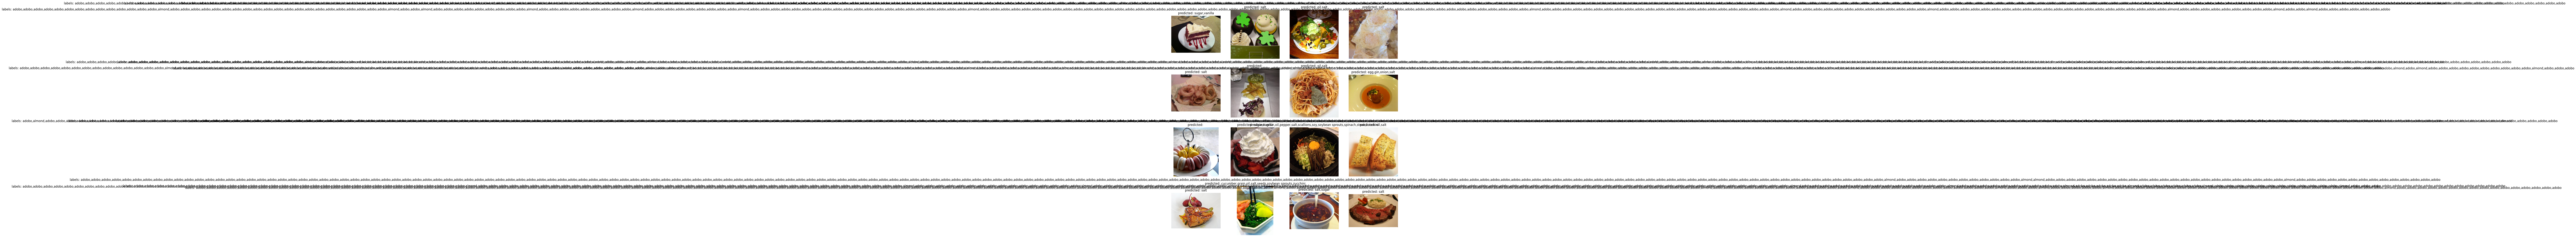

In [40]:
# load the model from the last epoch
model = create_model(model_name, num_classes=num_unique_ingredients)
model = model.to(device)
model_path = f'./models/{model_name}-pascal-epoch-4.pth'
model.load_state_dict(torch.load(model_path))

# show predictions for 4 random images in the test set
show_predictions(rows=4, cols=4)

[104, 164, 49, 224, 84, 124, 3, 183, 159, 125, 79]
[32, 198, 159, 191, 174, 74, 91, 211, 105, 185]
[170, 126, 124, 148, 212, 189, 183, 150, 159, 46, 62, 8, 213]
[207, 185, 212, 62, 105, 198, 145, 80]


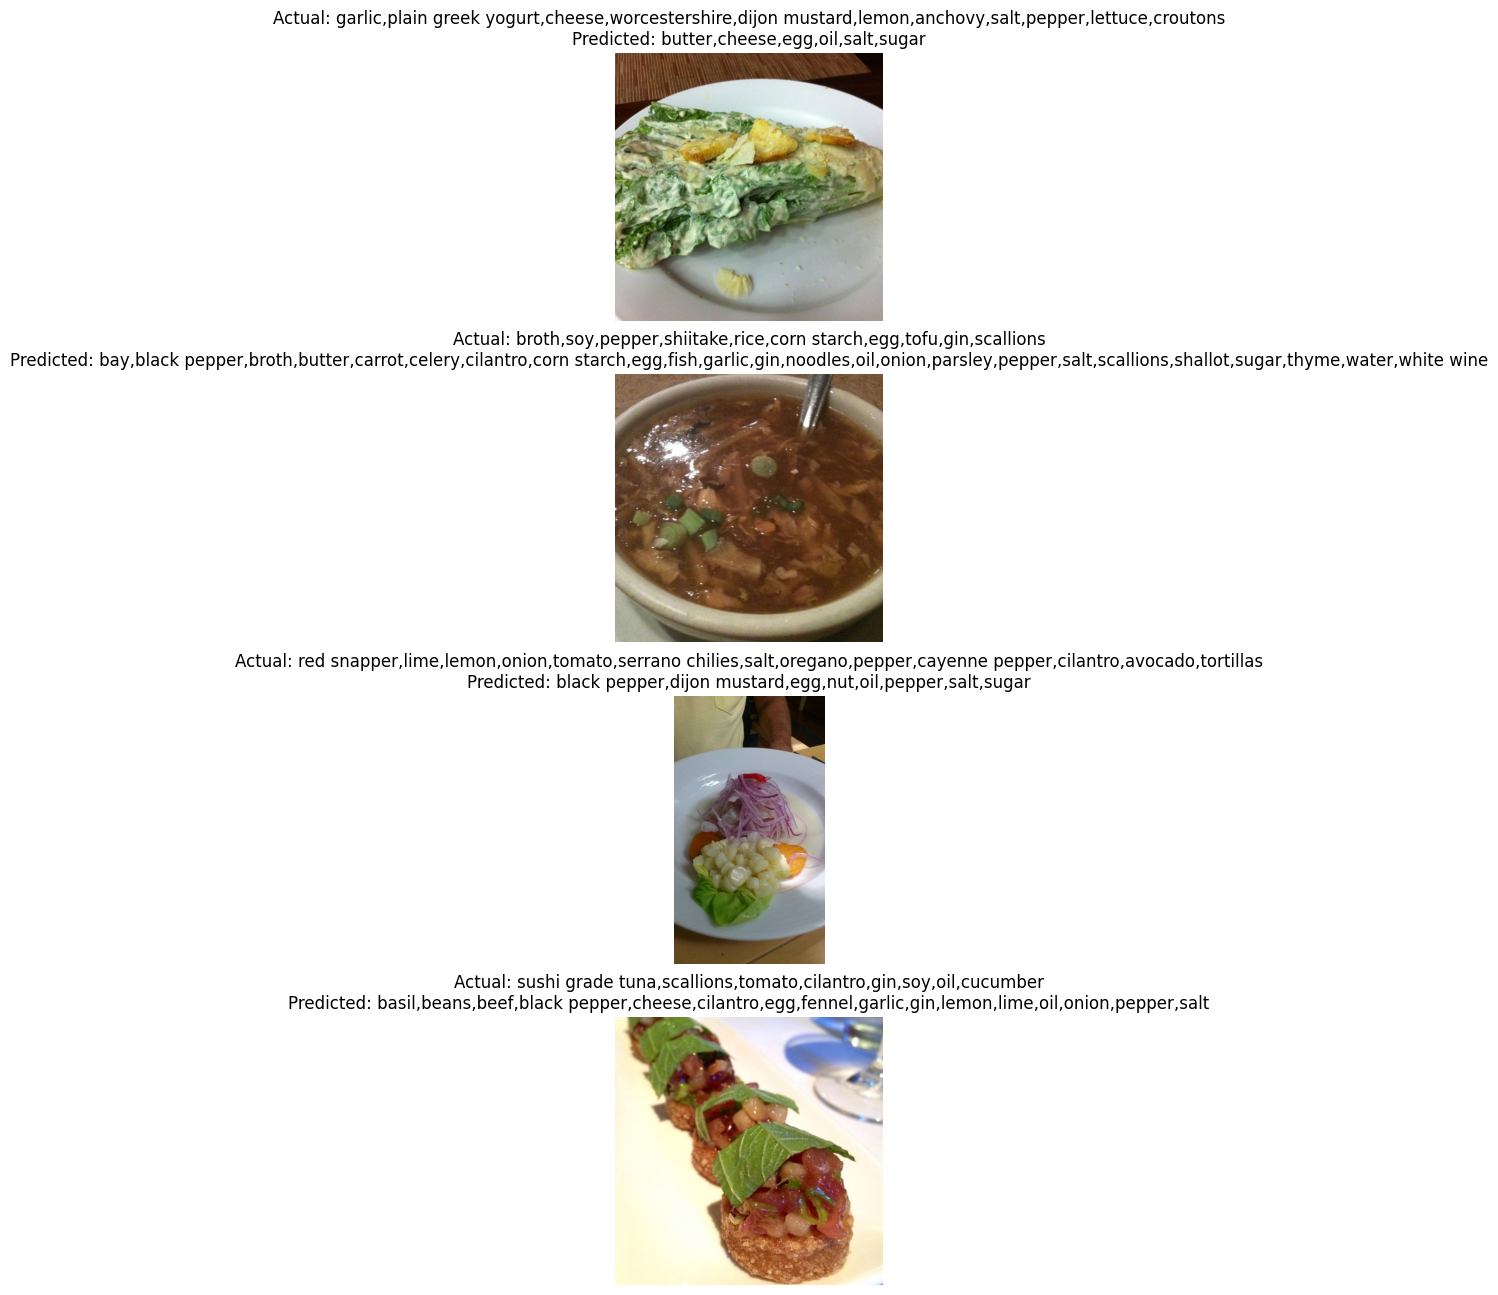

In [41]:
import torch

def show_predictions(rows=2, cols=4):
    model.eval()
    samples = test_dataset.shuffle(seed=4).select(range(rows * cols))
    fig = plt.figure(figsize=(cols * 4, rows * 4))
    
    for i in range(rows * cols):
        img = samples[i]['image']
        labels = samples[i]['labels']
        # labels_indices = labels.nonzero(as_tuple=False).squeeze()  # Finden Sie die Indizes der Labels, die 1 sind
        inputs = samples[i]['pixel_values'].unsqueeze(0).to(device)
        inputs = valid_tfms(img).unsqueeze(0).to(device)
        labels = samples[i]['ingredients']
        print(labels)
        
        labels_text = ','.join([idx_to_ingredient[label] for label in labels])
        
        with torch.no_grad():
            logits = model(inputs)
        
        predictions = logits.sigmoid() > 0.2  # Anwenden der Sigmoid und Umwandeln in binäre Vorhersagen

        predictions = predictions.cpu().float().numpy().flatten() # convert boolean predictions to float


        pred_labels = np.where(predictions==1)[0] # find indices where prediction is 1
        pred_labels = ','.join([idx_to_ingredient[label] for label in pred_labels]) # converting integer labels to string
        
        # predicted_indices = predictions.nonzero(as_tuple=False).squeeze()  # Finden Sie die Indizes der Vorhersagen, die 1 sind
        # pred_labels_text = ','.join([idx_to_ingredient[label.item()] for label in predicted_indices])
        
        label = f"Actual: {labels_text}\nPredicted: {pred_labels}"
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    
    plt.show()

show_predictions(rows=4, cols=1)
